# Assessing suitability of a location for thermal curtains and light shades to increase crop growth

## 1. Introduction
Plants do not grow effectively and get can get damaged in high temperatures and too much sun.[(1)](https://extension.oregonstate.edu/gardening/techniques/environmental-factors-affecting-plant-growth#:~:text=Temperature%20influences%20most%20plant%20processes,photosynthesis%2C%20transpiration%20and%20respiration%20increase.) Conversely dull, cool days inhibit photosynthesis and plants do not grow efficiently. If temperatures drop too low plants may be damaged and leaves dropped impacting growth for many weeks.  

Many greenhouse growers choose to whitewash the glass to reflect the heat and dissipate the light. However, adding (and removing) whitewash is time consuming, so the wash is only applied once per season, meaning if a cooler or cloudier spell of weather occurs the plants can't grow optimally. An increasingly popular alternative is fitting greenhouses with shading curtains which are easier to remove on cloudier days and can been drawn at night to retain heat. Through this project we investigate areas of Ontario, Canada to see the impact on the number of growing days on lettuce crops grown in greenhouse using the different thermal techniques.

The meteostat platform has been used to access the weather data for the basis of this project [(2)](https://dev.meteostat.net/). Due to the amount of data it has been stored in a MySQL database and analysed using charts and predictions made using SciKitLearn.

### 1.1 Table of contents
[2. Import needed tools](#2-import-needed-tools)

[3. Plant shading techniques](#3-plant-shading-techniques)

[3.1 Read in the data](#31-read-in-the-data)

[3.2 Plot the data](#32-plot-the-data)

[4. Finding the impact of the different thermal techniques](#4-finding-the-impact-of-the-different-thermal-techniques)

## 2. Import needed tools
To access, store and analyse our data we need to import a number of tools:

- **mysql.connector** - enables connections between python and MySQL [(3)](https://dev.mysql.com/doc/connector-python/en/)

- **requests** - used to request a webpage, in this case the page holding the datafiles [(4)](https://realpython.com/python-requests/)

- **gzip** - to handle and decompress gzip files[(5)](https://docs.python.org/3/library/gzip.html) as used at meteostat [(2)](https://dev.meteostat.net/).

- **BytesIO** - handles data as a file object [(6)](https://www.geeksforgeeks.org/stringio-and-bytesio-for-managing-data-as-file-object/)

- **json** - to work with data in the json format [(7)](https://realpython.com/python-json/)

- **pandas** - to create and handle dataframes [(8)](https://pandas.pydata.org/)

- **datetime** - to manipulate date and time data [(9)](https://docs.python.org/3/library/datetime.html)

- **numpy** - to work with numbers [(10)](https://numpy.org/)

- **matplotlib.pyplot** - plotting tool [(11)](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html)

- **seaborn** - plotting statistical data [(12)](https://seaborn.pydata.org/)

- **sklearn.metrics import r2_score** - calculates how well the model fits the data [(13)](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.r2_score.html)

- **sklearn.ensemble import RandomForestRegressor** - machine learning technique to predict numerical values[(14)](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)[(15)](https://www.geeksforgeeks.org/random-forest-regression-in-python/)

- **sklearn.model_selection import train_test_split** - split a dataset to train the machine learning model [(16)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)[(17)](https://realpython.com/train-test-split-python-data/)

- **sklearn.metrics import mean_squared_error** - calculate the average squared difference between the predictions and actual data [(18)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)[(19)](https://www.geeksforgeeks.org/python-mean-squared-error/)

- **datetime import timedelta** - duration or difference between two date [(20)](https://docs.python.org/3/library/datetime.html)
  
- **scipy import stats** - access statistical functions [(21)](https://docs.scipy.org/doc/scipy-1.15.0/reference/stats.html)

- **decimal import Decimal** - to work with decimals [(22)](https://docs.python.org/3/library/decimal.html)

In [1]:
# Create the mySQL database
import mysql.connector as msql

# Import the data and unzip it
import requests
import gzip
from io import BytesIO
import json

# Create the dataframe and manipulate it
import pandas as pd
import datetime as dt
import numpy as np

# Plot the data
import matplotlib.pyplot as plt
import seaborn as sns

# Regression analysis
from sklearn.metrics import r2_score
from scipy import stats

# Work with decimals
from decimal import Decimal

# Regression and machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from datetime import timedelta

## 3. Plant shading techniques
Each of the different plant shading techniques have different characteristics and efficiencies. White washing requires good knowledge on when to white wash and remove it, but is very cheap. Thermal curtains are easier to use, can be quickly and easily moved into place, but are more expensive to buy. Propriety data has been amended for this project to protect intellectual property but the techniques used to analyse the data are still valid.

### 3.1 Read in the thermal techniques data
The data about the performance of difference thermal techniques are saved in a csv file. This dataset lists the external temperature and internal temperature from other greenhouses in the same location using the different thermal techniques and one control greenhouse. This data is first read into a dataframe call `df_tech`.

In [18]:
# Location of the data
DATADIR = "C:/Users/kirst/OneDrive - Atlantic TU/pfda/project/"
FILENAME = "thermal_data.csv"

# Read the data into a dataframe
df_tech = pd.read_csv (DATADIR + FILENAME)

### 3.2 Plot the thermal techniques data
Now the data is in a dataframe it can quickly be visualised by plotting using `matplotlib.pyplot` [(11)](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html). To create a line for each of the thermal techiques these variables are set to y1, y2 y3, etc [(23)](https://www.geeksforgeeks.org/plot-multiple-lines-in-matplotlib/), a particular column is extracted from the dataframe using the format `dataframe_name['column_name]`.

The data is plotted using matplotlib's scatter plot [(24)](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) and the axes and chart labelled.

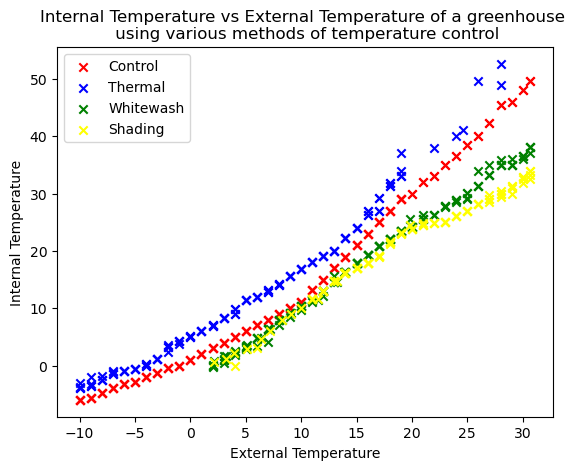

In [19]:
# Set the parameters for the plot
x = df_tech['External']
y1 = df_tech['Control']
y2 = df_tech['Thermal']
y3 = df_tech['Whitewash']
y4 = df_tech['Shading']

# Plot the data
plt.scatter(x,y1, marker='x', color='red', label='Control')
plt.scatter(x,y2, marker='x', color='blue', label='Thermal')
plt.scatter(x,y3, marker='x', color='green', label='Whitewash')
plt.scatter(x,y4, marker='x', color='yellow', label='Shading')

# Label the chart
plt.xlabel('External Temperature')
plt.ylabel('Internal Temperature')
plt.title('Internal Temperature vs External Temperature of a greenhouse \n using various methods of temperature control')
plt.legend()

# Show the plot
plt.show()


## 4. Finding the impact of the different thermal techniques

### 4.1 Whitewash
Whitewashing is the traditional approach to cooling a greenhouse. Once temperatures start to rise in the spring a layer of white wash is painted onto the roof of the greenhouse. This whitewash reduces the amount of solar gain and cools the day time temperatures of the the greenhouse. The chart above shows that the relationship between the external temperature and the temperature inside a white washed greenhouse is basically linear (green markers). Visualising the whitewashing data on its own makes this relationship clearer and check if there are any missing values using `.info()`.




In [23]:
whitewash_data = df_tech[['Whitewash', 'External']]
whitewash_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Whitewash  155 non-null    float64
 1   External   210 non-null    float64
dtypes: float64(2)
memory usage: 3.4 KB


There are missing values so we'll use the `dropna` technique to remove them [(25)](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html). 

In [24]:
whitewash_data = whitewash_data.dropna()

whitewash_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 155 entries, 52 to 209
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Whitewash  155 non-null    float64
 1   External   155 non-null    float64
dtypes: float64(2)
memory usage: 3.6 KB


Now we have a clean dataset. We can plot the data and see there is a clear linear relationship between the data.

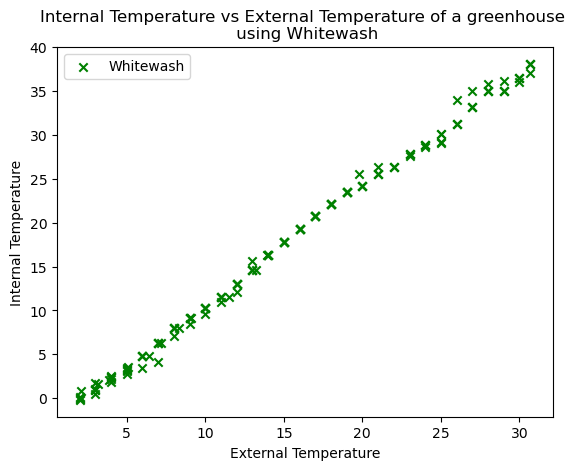

In [25]:
# Set the x and y values
x = whitewash_data['External']
y1 = whitewash_data['Whitewash']

# Plot the data
plt.scatter(x, y1, marker='x', color='green', label='Whitewash')

# Label the chart
plt.xlabel('External Temperature')
plt.ylabel('Internal Temperature')
plt.title('Internal Temperature vs External Temperature of a greenhouse \n using Whitewash')
plt.legend()

# Show the plot
plt.show()

To assess the quality of the linear relationship we can complete a linear regression analysis and calculate the r-value using the stats import ([21])(https://docs.scipy.org/doc/scipy-1.15.0/reference/stats.html) and the linear regression function [(26)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html). I have based my code on the example at [(27 w3 schools)](https://www.w3schools.com/python/python_ml_linear_regression.asp). 

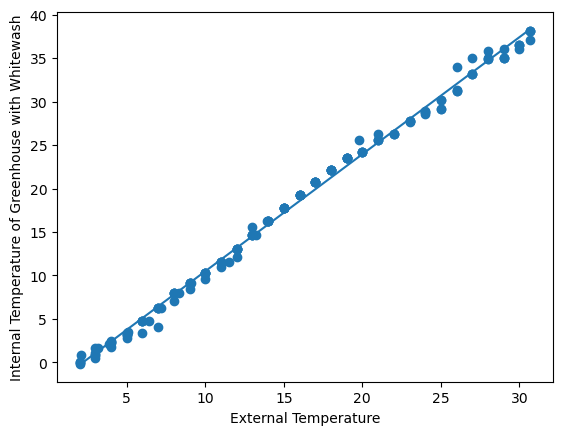

The R value is:  0.9981179494414084
The P value is:  2.0725328470034026e-187
The standard error is:  0.006689307022905101
The slope is:  1.3467361162582767
The intercept is:  -2.9829482950329833


In [ ]:
# Run the linear regression method from scipy
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Create a function to predict the internal temperature of a whitewashed greenhouse
def myfunc(x):
  return slope * x + intercept

# Run the function based on external temperature
mymodel = list(map(myfunc, x))

# Plot the data
plt.scatter(x, y1)
plt.plot(x, mymodel)
plt.xlabel('External Temperature')
plt.ylabel('Internal Temperature of Greenhouse with Whitewash')

# Show the plot
plt.show()

# Print the results
print("The R value is: ", r_value)
print("The P value is: ", p_value)
print("The standard error is: ", std_err)
print("The slope is: ", slope)
print("The intercept is: ", intercept)

The high r-value shows there is a strong, linear relationship between the external temperature and internal temperature of a white washed greenhouse.

### 4.2 Impact of thermal curtains
When the data for the use of thermal curtains in the greenhouse is plotted there is a different type of relationship. At lower external temperatures the temperature is maintained at a higher level and when hotter this is exacerbated by the curtains. This type of trend is called polynomial [(28)](https://www.khanacademy.org/math/algebra2/x2ec2f6f830c9fb89:poly-graphs/x2ec2f6f830c9fb89:poly-graphs-together/a/graphs-of-polynomials)

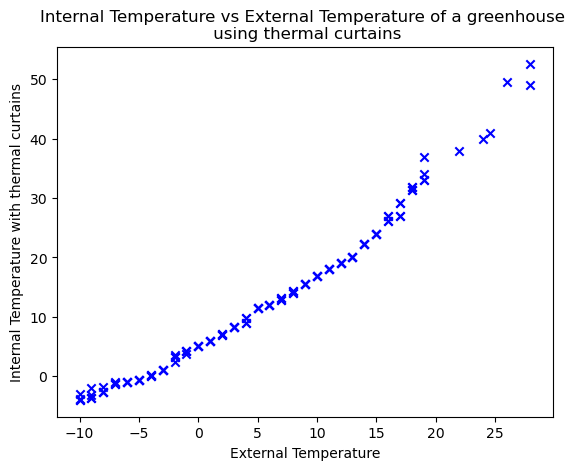

In [38]:
# Create a dataframe for the thermal curtain data
thermal_data = df_tech[['Thermal', 'External']]

# Drop any rows with missing data
thermal_data = thermal_data.dropna()

# Set the x and y values
x = thermal_data['External']
y2 = thermal_data['Thermal']

# Plot the data
plt.scatter(x, y2, marker='x', color='blue', label='Thermal')
plt.xlabel('External Temperature')
plt.ylabel('Internal Temperature with thermal curtains')
plt.title('Internal Temperature vs External Temperature of a greenhouse \n using thermal curtains')

# Show the plot
plt.show()

To look at the trend and try to fit a line to we we can use `polyfit` in `numpy` [(29)], I based my code on this video tutorial [(https://www.youtube.com/watch?v=-Ovf9yAFhqI&ab_channel=ShameelAbdulla)](https://www.youtube.com/watch?v=-Ovf9yAFhqI&ab_channel=ShameelAbdulla).

The equation of the trend line is:          2
0.02225 x + 1.029 x + 4.544


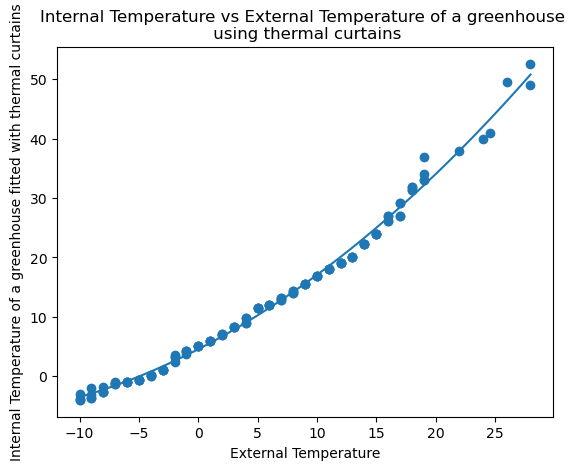

In [37]:
# Using numpy to create a polynomial regression
p = np.polyfit(x, y2, 2)
fit = np.poly1d(p)
print(f"The equation of the trend line is: {fit2}")

# Plot the regression line
x_new = np.linspace(x.min(), x.max(), 100)
y_model = fit(x_new)

# Plot the data
plt.scatter(x, y)
plt.plot(x_new, y_model)

# Label the chart
plt.xlabel('External Temperature')
plt.ylabel('Internal Temperature of a greenhouse fitted with thermal curtains')
plt.title('Internal Temperature vs External Temperature of a greenhouse \n using thermal curtains')
plt.show()


### 4.3 Impact of shading
The plot of the data again shows a slight polynomial fit, perhaps as the shading curtains also act as a low-level insulator.


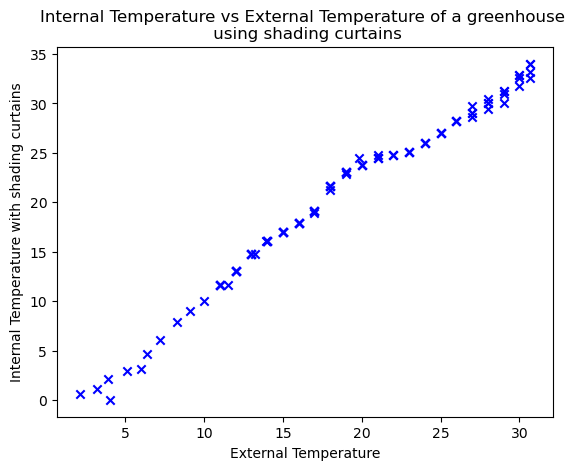

In [47]:
# Create a dataframe for the thermal curtain data
shading_data = df_tech[['Shading', 'External']]

# Drop any rows with missing data
shading_data = shading_data.dropna()

# Set the x and y values
x = shading_data['External']
y3 = shading_data['Shading']

# Plot the data
plt.scatter(x, y3, marker='x', color='blue')
plt.xlabel('External Temperature')
plt.ylabel('Internal Temperature with shading curtains')
plt.title('Internal Temperature vs External Temperature of a greenhouse \n using shading curtains')

# Show the plot
plt.show()

Once again using `numpy polyfit` we can understand the relationship between the external temperature and the internal temperature of a greenhouse using shading curtains.

The equation of the trend line is:
           2
-0.01653 x + 1.734 x - 5.173


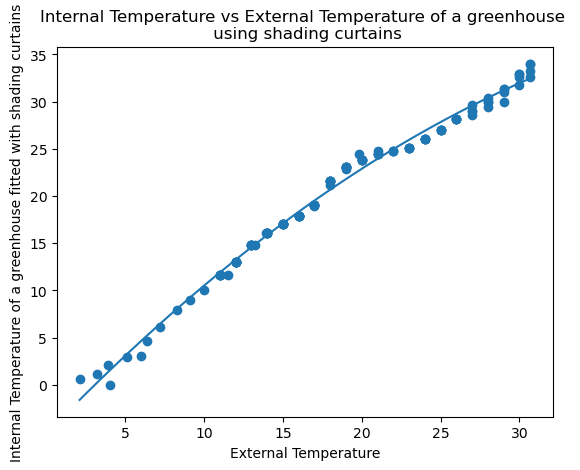

In [50]:
# Using numpy to create a polynomial regression
p = np.polyfit(x, y3, 2)
fit2 = np.poly1d(p)
print(f"The equation of the trend line is:\n {fit2}")

# Plot the regression line
x_new = np.linspace(x.min(), x.max(), 100)
y_model = fit2(x_new)

# Plot the data
plt.scatter(x, y3)
plt.plot(x_new, y_model)

# Label the chart
plt.xlabel('External Temperature')
plt.ylabel('Internal Temperature of a greenhouse fitted with shading curtains')
plt.title('Internal Temperature vs External Temperature of a greenhouse \n using shading curtains')
plt.show()


## 5. Create a database to store the weather data
Due to the large amounts of data needed for this analysis. A MySQL database needs to be created. MySQL offers the ability to store very large amounts of data in a structured and easily accessible way, where the data is persistent. 

To create the database we first set the connection parameters for the database and create the cursor to enable the connection for making SQL queries.


In [ ]:
# Set the parameters for the connection
db = msql.connect(host='localhost', user='root',password='')

# Create the cursor
cursor = db.cursor()

# Execute SQL query
cursor.execute('CREATE DATABASE weather')
print('The database "weather" has been created')

# Close the connection
cursor.close()
db.close()

### 6.1 Create a table for the weather station data
Within the database a table needs to be created for each of the data sources. The first table will hold a list of the weather stations [(4)](https://dev.meteostat.net/bulk/stations.html#endpoints). The data about all the weather stations is available at: https://bulk.meteostat.net/v2/stations/lite.json.gz. It is compressed using `gzip` so the file needs to be decompressed before creating the dataframe and inserting the information into the database.

In [ ]:
try:
    # Connect to MySQL
    con = msql.connect(host='localhost', database='weather', user='root', password='')

    if con.is_connected():
        cursor = con.cursor()
        cursor.execute("SELECT DATABASE();")
        record = cursor.fetchone()
        print(f"You're connected to database: {record}")
        
        # Drop the table if it exists
        cursor.execute('DROP TABLE IF EXISTS stations_data')
        print('Creating table....')
        
        # Create the table
        sql = """CREATE TABLE stations_data 
            (id VARCHAR(10) PRIMARY KEY, 
            name JSON, 
            country CHAR(2), 
            region VARCHAR(10), 
            national_id VARCHAR(10), 
            wmo_id VARCHAR(10), 
            icao_id VARCHAR(10), 
            iata_id VARCHAR(25), 
            latitude DECIMAL(9,6), 
            longitude DECIMAL(9,6), 
            elevation INT, 
            timezone VARCHAR(25),
            history JSON, 
            hourly_start DATE, 
            hourly_end DATE, 
            daily_start DATE,
            daily_end DATE,
            monthly_start YEAR,
            monthly_end YEAR,
            normals_start YEAR,
            normals_end YEAR
)"""
        cursor.execute(sql)
        print("Table is created....")

except msql.Error as err:
    print(err.msg)

finally:
    if con.is_connected():
        cursor.close()
        con.close()

### 6.2 Read in the weather station data

Then the weather stations table needs to be populated.

In [ ]:
# File name and location
url = "https://bulk.meteostat.net/v2/stations/full.json.gz"
file_name = "full.json.gz"

# Download the file
response = requests.get(url, stream=True)
with open(file_name, 'wb') as f:
    f.write(response.content)

# Decompress the file
with gzip.open(file_name, 'rt', encoding='utf-8') as gz_file:
    stations_file = json.load(gz_file)

# Connect to the MySQL Database
try:
    con = msql.connect(host='localhost', database='weather', user='root', password='')
    if con.is_connected():
        cursor = con.cursor()
        print("Connected to the database.")

        # Prepare SQL statement for data insertion
        sql_insert = """
            INSERT INTO stations_data (
                id, name, country, region, national_id, wmo_id, icao_id, iata_id,
                latitude, longitude, elevation, timezone, history,
                hourly_start, hourly_end, daily_start, daily_end,
                monthly_start, monthly_end, normals_start, normals_end
            ) VALUES (
                %(id)s, %(name)s, %(country)s, %(region)s, %(national_id)s, %(wmo_id)s, %(icao_id)s, %(iata_id)s,
                %(latitude)s, %(longitude)s, %(elevation)s, %(timezone)s, %(history)s,
                %(hourly_start)s, %(hourly_end)s, %(daily_start)s, %(daily_end)s,
                %(monthly_start)s, %(monthly_end)s, %(normals_start)s, %(normals_end)s
            )
        """

        # Insert Data into MySQL Table
        for station in stations_file:
            data = {
                'id': station.get('id'),
                'name': json.dumps(station.get('name', {})),  # Convert dictionary to JSON string
                'country': station.get('country'),
                'region': station.get('region'),
                'national_id': station.get('national'),
                'wmo_id': station.get('wmo'),
                'icao_id': station.get('icao'),
                'iata_id': station.get('iata'),
                'latitude': station.get('latitude'),
                'longitude': station.get('longitude'),
                'elevation': station.get('elevation'),
                'timezone': station.get('timezone'),
                'history': json.dumps(station.get('history', [])),  # Convert list to JSON string
                'hourly_start': station.get('inventory', {}).get('hourly', {}).get('start'),
                'hourly_end': station.get('inventory', {}).get('hourly', {}).get('end'),
                'daily_start': station.get('inventory', {}).get('daily', {}).get('start'),
                'daily_end': station.get('inventory', {}).get('daily', {}).get('end'),
                'monthly_start': station.get('inventory', {}).get('monthly', {}).get('start'),
                'monthly_end': station.get('inventory', {}).get('monthly', {}).get('end'),
                'normals_start': station.get('inventory', {}).get('normals', {}).get('start'),
                'normals_end': station.get('inventory', {}).get('normals', {}).get('end'),
            }
            cursor.execute(sql_insert, data)

        # Commit the transaction
        con.commit()
        print("Data inserted successfully.")

# Print details if an error occurs
except msql.Error as err:
    print(f"Error: {err}")

# Close the connection
finally:
    if con.is_connected():
        cursor.close()
        con.close()
        print("MySQL connection is closed.")

### 6.3 Select the country of interest


In [ ]:
con = msql.connect(host='localhost', database='weather', user='root', password='')

cursor = con.cursor()

sql = "SELECT DISTINCT country FROM stations_data"

cursor.execute(sql)
results = cursor.fetchall()
print("The country codes are explained at: https://www.iban.com/country-codes")
print(f"The countries available are:")
for row in results:
    print(row)

cursor.close()
con.close()

The user should be prompted to select the country of interest. 


In [ ]:
try:
    # Connect to the database
    con = msql.connect(host='localhost', database='weather', user='root', password='')
    if con.is_connected():
        cursor = con.cursor()
        
        # Get user to input the country code
        chosencountry = input(str("Enter the country of interest, using the two digit code: ")).strip().upper()
        
        # Check the user input is valid
        if len(chosencountry) != 2:
            print("Invalid country code. Please enter a valid 2- character country code.")
        else: # Exectute the SQL query
            query = sql = "SELECT DISTINCT region FROM stations_data WHERE country = %s"
            cursor.execute(query, (chosencountry,)) 
            
            # Fetch and display the results
            results = cursor.fetchall()
            if results:
                print(f"The regions within {chosencountry} available are:")
                for row in results:
                    print(row)
            else:
                print(f"No regions found for country code: {chosencountry}")
                
except msql.Error as err:
    print(err)

finally:
    if con.is_connected():
        cursor.close()
        con.close()


### 6.4 Select the weather stations in the country and region of interest

In [ ]:
try:
    # Connect to the database
    con = msql.connect(host='localhost', database='weather', user='root', password='')
    if con.is_connected():
        cursor = con.cursor()
        
        # Get user to input the region code
        chosenregion = input(str("Enter the region of interest, using the two digit code: ")).strip().upper()
        
        # Check the user input is valid
        if len(chosenregion) != 2:
            print("Invalid region code. Please enter a valid 2- character region code.")
        else: # Execute the SQL query
            query ="SELECT id FROM stations_data WHERE country = %s AND region = %s AND daily_start IS NOT NULL"
            cursor.execute(query, (chosencountry, chosenregion,)) 
            
            # Fetch and display the results
            station_ids = [str(row[0]) for row in cursor.fetchall()]
            if results:
                print(f"The stations within {chosenregion} are:")
                for row in station_ids:
                    print(row)
            else:
                print(f"No stations found for region code: {chosenregion} in country code: {chosencountry}")
                
except msql.Error as err:
    print(err)

finally:
    if con.is_connected():
        cursor.close()
        con.close()

### 6.5 Create a table for the weather data for each region

In [ ]:
table_name = f"{chosencountry}_{chosenregion}_data".lower()

try:
    # Connect to MySQL
    con = msql.connect(host='localhost', database='weather', user='root', password='')

    if con.is_connected():
        cursor = con.cursor()
        cursor.execute("SELECT DATABASE();")
        record = cursor.fetchone()
        print(f"You're connected to database: {record}")
        
        # Drop the table if it exists
        drop_query = f"DROP TABLE IF EXISTS `{table_name}`"
        cursor.execute(drop_query)
        print(f"Table '{table_name}' dropped if it existed.")
        
        # Create the table
        create_query = f"""
        CREATE TABLE `{table_name}` (
            id VARCHAR(10) PRIMARY KEY, 
            station_id VARCHAR(10),
            date DATE,
            avg_temp DECIMAL(5,1), 
            min_temp DECIMAL(5,1),
            max_temp DECIMAL(5,1),
            month INT,
            year YEAR
        )
        """
        cursor.execute(create_query)
        print(f"Table '{table_name}' is created successfully.")

except msql.Error as err:
    print(err.msg)

finally:
    if con.is_connected():
        cursor.close()
        con.close()

Now the table needs to be populated with the data for each of the weather stations in the chosen country and region.

In [ ]:
table_name = f"{chosencountry}_{chosenregion}_data".lower()

# Connect to the MySQL Database
try:
    con = msql.connect(host='localhost', database='weather', user='root', password='')
    if con.is_connected():
        cursor = con.cursor()
        print("Connected to the database.")

        # Insert Data into MySQL Table
        for station in station_ids:
            print(f"Processing station: {station}")

            # Download the file
            url = f"https://bulk.meteostat.net/v2/daily/{station}.csv.gz"
            response = requests.get(url)
            response.raise_for_status()  # Ensure the request was successful

            if response.status_code == 200:
                # Read the CSV file into a DataFrame
                stations_data = gzip.GzipFile(fileobj=BytesIO(response.content))
                df = pd.read_csv(stations_data, usecols=[0, 1, 2, 3], names=['date', 'avg_temp', 'min_temp', 'max_temp'], parse_dates=['date'])
                df.dropna(inplace=True)

                # Add a station ID column
                df['station_id'] = station

                # Add month and year columns
                df["year"] = df["date"].dt.year
                df["month"] = df["date"].dt.month

                counter = 0
                for _, row in df.iterrows():
                    # Create a unique ID for each row
                    id = f"{row['station_id']}_{counter}"
                    
                    # Prepare SQL statement for data insertion
                    sql_insert = f"""
            INSERT INTO `{table_name}` (id, station_id, date, avg_temp, min_temp, max_temp, month, year) VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
        """
                    # Insert data into MySQL table
                    cursor.execute(sql_insert,(
                        id,
                        row["station_id"],
                        row["date"].date(),
                        row.get("avg_temp", None),
                        row.get("min_temp", None),
                        row.get("max_temp", None),
                        row["month"],
                        row["year"],
                    ))
                    counter += 1
                con.commit()
                print(f"Data from station {station} inserted successfully.")
            else:
                print(f"Failed to download data for station: {station}")
except msql.Error as err:
    print(f"Error: {err}")

# Close the connection
finally:
    if con.is_connected():
        cursor.close()
        con.close()
        print("MySQL connection is closed.")






## 7. Analysing the weather data
https://dev.meteostat.net/bulk/daily.html#endpoints

### 7.1 Average the temperature data by month

First get the user to select a station id


In [89]:

chosencountry = input(str("Enter the country of interest, using the two digit code: "))
chosenregion = input(str("Enter the region of interest, using the two digit code: "))


Use this choice to extract the daily average temperature data for the station of interest from the database.

In [ ]:
table_name = f"{chosencountry}_{chosenregion}_data".lower()

con = None
try:
    # Connect to the database
    con = msql.connect(host='localhost', database='weather', user='root', password='')
    if con.is_connected():
        cursor = con.cursor()
        
        #Request user to input the station ID
        chosenstation = input(str("Enter the station ID of interest: ").strip().upper())
        
        if chosenstation in station_ids:
            print(f"Station {chosenstation} is available.")
        else:
            print(f"Please choose from one of the following station IDs: {station_ids}")
        
        # Execute the SQL query
        query =f"SELECT date, avg_temp, min_temp, max_temp, month, year FROM `{table_name}` WHERE station_id = %s"
        cursor.execute(query, (chosenstation,))
        rows = cursor.fetchall()
        
        # Create a DataFrame
        df= pd.DataFrame(rows)
        df.columns=['date', 'avg_temp', 'min_temp', 'max_temp', 'month', 'year']
        
        # Print the first 5 rows
        print(df.head(5))

except msql.Error as err: 
    print(err)

finally:
    if con and con.is_connected():
        cursor.close()
        con.close()

### 7.2 Plot the data for the average temperature


In [ ]:
# Group by year and month, then calculate the average temperature for each month
monthly_avg = df.groupby(["year", "month"])["avg_temp"].mean().reset_index()

# Plot the data
plt.figure(figsize=(12, 6))
years = monthly_avg["year"].unique()

# Draw a horizontal line at y_value
plt.axhline(y=lettuce_range1, color='r', linestyle='--', label=f'y = Lower optimal growth limit for lettuce: {lettuce_range1}')
plt.axhline(y=lettuce_range2, color='r', linestyle='--', label=f'y = Upper optimal growth limit for lettuce: {lettuce_range2}')
plt.axhline(y=lettuce_min, color='b', linestyle='--', label=f'y = Damage limit for lettuce: {lettuce_min}')
for year in years:
    year_data = monthly_avg[monthly_avg["year"] == year]
    plt.plot(year_data["month"], year_data["avg_temp"], marker="o", label=str(year))


plt.title(f"Average Monthly Temperature for Station {chosenstation} in {chosencountry} - {chosenregion}")
plt.xlabel("Month")
plt.ylabel("Average Temperature (°C)")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.legend(title="Year", loc="best", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()


### 7.3 Average minimum temperatures

In [ ]:
df.dropna(subset=['min_temp'], inplace=True)
# Group by year and month, then calculate the minimum average temperature for each month
min_monthly_avg = df.groupby(["year", "month"])["min_temp"].mean().reset_index()

# Plot the data
plt.figure(figsize=(12, 6))
years = min_monthly_avg["year"].unique()

# Draw a horizontal line at y_value
plt.axhline(y=lettuce_range1, color='r', linestyle='--', label=f'y = Lower optimal growth limit for lettuce: {lettuce_range1}')
plt.axhline(y=lettuce_min, color='b', linestyle='--', label=f'y = Damage limit for lettuce: {lettuce_min}')

# Plot the data
for year in years:
    year_data = min_monthly_avg[min_monthly_avg["year"] == year]
    plt.plot(year_data["month"], year_data["min_temp"], marker="o", label=str(year))


plt.title(f"Average Minimum Monthly Temperature for Station {chosenstation} in {chosencountry} - {chosenregion}")
plt.xlabel("Month")
plt.ylabel("Average Minimum Temperature (°C)")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.legend(title="Year", loc="best", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

## 7.4 Using Scikit Learn to predict the weather
https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html#sphx-glr-auto-examples-linear-model-plot-ols-py

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from datetime import timedelta

# Prepare Features
df['date'] = pd.to_datetime(df['date'])
df['day_of_year'] = df['date'].dt.dayofyear
#df['year'] = df['date'].dt.year

# Features: Day of the year and year; Target: Average temperature
X = df[['day_of_year', 'year']]
y = df['avg_temp']

# Step 4: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Train Model
model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# Step 6: Evaluate Model
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse:.2f}°C")

# Step 7: Predict for Next 5 Years
future_years = pd.date_range(start=df['date'].max() + timedelta(days=1), 
                             periods=5 * 365, freq='D')
future_df = pd.DataFrame({
    'date': future_years,
    'day_of_year': future_years.day_of_year,
    'year': future_years.year
})
future_predictions = model.predict(future_df[['day_of_year', 'year']])
future_df['predicted_tavg'] = future_predictions

# Step 8: Plot Known Data and Predictions
plt.figure(figsize=(14, 7))

# Plot historical data
plt.plot(df['date'], df['avg_temp'], label='Historical Data', alpha=0.6)

# Plot predictions
plt.plot(future_df['date'], future_df['predicted_tavg'], label='Predictions', alpha=0.8)

plt.title(f'Historical and Predicted Average Temperatures for station {chosenstation} in {chosencountry} - {chosenregion}')
plt.xlabel('Date')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.grid()
plt.show()

# Step 9: Save Predictions
future_df.to_csv('predicted_temperatures.csv', index=False)
print(f"Predictions saved to 'predicted_temperatures.csv'")

## 5. The test plants
"Head lettuce is the most important salad vegetable gown in the United States" [(2)](https://content.ces.ncsu.edu/lettuce). The optimum growing temperature for head lettuce is 15-18°C. At 20-26°C the plants start to flower and produce seed and need replacing and temperatures below 0°C will kill the plants.


In [ ]:
lettuce_min = 0
lettuce_max = 20
lettuce_range1 = 15
lettuce_range2 = 20

Tomatoes are grown across the world and are an important staple in many cuisines. To increase their range and season many are grown in greenhouses. The optimal conditions for growth are 21-27°C with temperatures not dropping below 16°C or exceeding 29°C [(3)](https://drygair.com/blog/what-are-the-ideal-conditions-for-greenhouse-tomatoes/).

In [ ]:
tomato_min = 16
tomato_max = 29
tomato_range1 = 21
tomato_range2 = 27

## 8. Analysing the impact of thermal curtains on temperature




In [ ]:
# Calculate the number of cold days per month and year
cold_days_count = (df.groupby(["year", "month"]).size().reset_index(name="cold_days_count"))

# Print the results
print(cold_days_count)



### 8.1 Calculate the impact of the thermal curtains



In [ ]:
print(f)

In [ ]:
# Define the regression function
def f(temp):
    # Ensure temp is converted to a float for compatibility
    temp = float(temp)
    return 0.03538656 * temp**2 + 0.70891686 * temp + 6.14413969

# Convert min_temp column to float if necessary
df["avg_temp"] = df["avg_temp"].astype(float)

# Generate prediction for the internal temperature
df["temp_curtains"] = df["avg_temp"].apply(f)

# Identify cold days where temperature is below the threshold
df["cold_days_curtains"] = df["temp_curtains"] < lettuce_range1

# Display results
print(df.head())

# Filter and print rows where cold days are identified
cold_days_count_thermal = df[df["cold_days_curtains"]]
print(cold_days_count_thermal)


In [ ]:
# Ensure 'date' is in datetime format
df["date"] = pd.to_datetime(df["date"])

# Group by year and month, and count the number of occurrences
cold_days_count_thermal = cold_days_count_thermal.groupby(["year", "month"]).size().reset_index(name="cold_days_count_thermal")

# Display the result
print(cold_days_count_thermal)

In [ ]:
# Merge both results into a single DataFrame
result = pd.merge(
    cold_days_count,
    cold_days_count_thermal,
    on=["year", "month"],
    how="outer",
).fillna(0)  # Fill NaN with 0 for months with no cold days

# Calculate extra growing days
result["extra_days"] = result["cold_days_count"] - result["cold_days_count_thermal"]

# Group by year and sum the extra growing days
extra_growing_days_by_year = result.groupby("year")["extra_days"].sum().reset_index()

# Rename columns for clarity
extra_growing_days_by_year.rename(columns={"extra_days": "total_extra_days"}, inplace=True)

# Display the result
print(extra_growing_days_by_year)

In [ ]:
plt.bar(extra_growing_days_by_year["year"], extra_growing_days_by_year["total_extra_days"])
plt.title("Extra Growing Days per Year")
plt.xlabel("Year")
plt.ylabel("Extra Growing Days when using thermal curtains")
plt.show()

### 8.2 Plot the extra growing days by month and year

In [ ]:
# Plot the data
for year in years:
    year_data = result[result["year"] == year]
    plt.plot(year_data["month"], year_data["extra_days"], marker="o", label=str(year))

plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.title("Extra Growing Days per Month when Using Thermal Curtains")
plt.xlabel("Month")
plt.ylabel("Extra Growing Days per month")
plt.legend(title="Year", loc="best", bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
print(result)

# Add a column for 5-year bins
result["5_year_period"] = (result["year"] // 5) * 5

# Calculate the 5-year average for each month
monthly_averages = (
    result.groupby(["5_year_period", "month"])["extra_days"]
    .mean()
    .reset_index()
)

# Pivot the data for easier plotting
pivot_table = monthly_averages.pivot(index="month", columns="5_year_period", values="extra_days")

# Plot the chart
plt.figure(figsize=(12, 6))

# Plot each 5-year period as a line
for period in pivot_table.columns:
    plt.plot(
        pivot_table.index,
        pivot_table[period],
        label=f"{period}-{period + 4}"
    )

# Customize the plot
plt.xlabel("Month")
plt.ylabel("Average Extra Growing Days")
plt.title("5-Year Average of Extra Growing Days by Month")
plt.xticks(ticks=range(1, 13), labels=[
    "Jan", "Feb", "Mar", "Apr", "May", "Jun", 
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
])
plt.legend(title="5-Year Period")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


## Sci Kit Learn
https://www.askpython.com/python/examples/weather-data-clustering

In [ ]:
table_name = f"{chosencountry}_{chosenregion}_data".lower()

try:
    # Connect to the database
    con = msql.connect(host='localhost', database='weather', user='root', password='')
    if con.is_connected():
        cursor = con.cursor()
                
        # Execute the SQL query
        query =f"SELECT id, date, avg_temp, min_temp, max_temp, month, year FROM `{table_name}` WHERE station_id = %s"
        cursor.execute(query, (chosenstation,))
        rows = cursor.fetchall()
        
        # Create a DataFrame
        df= pd.DataFrame(rows)
        df.columns=['id', 'date', 'avg_temp', 'min_temp', 'max_temp','month', 'year']
        
        # Print the first 5 rows
        print(df.head(5))

except msql.Error as err: 
    print(err)

finally:
    if con.is_connected():
        cursor.close()
        con.close()

https://www.askpython.com/python/examples/weather-data-clustering

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from itertools import cycle, islice
from pandas.plotting import parallel_coordinates

# Select every 10th row for faster processing

df.dropna(inplace=True)
sampled_df = df.iloc[::10]
sampled_df.shape

# Select features for clustering
features = ['avg_temp', 'min_temp', 'max_temp']
selected_df = sampled_df[features]

# Standardize the features
X = StandardScaler().fit_transform(selected_df)

# Apply KMenas clustering
KM = KMeans(n_clusters=10)
model = KM.fit(X)
centers = model.cluster_centers_

# Visualize the clusters

# 1. Function that generates a DataFrame with a Cluster Number column.
 
def pd_centers(featuresUsed, centers):
    colNames = list(featuresUsed)
    colNames.append('prediction')
    Z = [np.append(A, index) for index, A in enumerate(centers)]
    P = pd.DataFrame(Z, columns=colNames)
    P['prediction'] = P['prediction'].astype(int)
    return P
 
# 2. Function that creates Parallel Plots
 
def parallel_plot(data):
    my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(data)))
    plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
    parallel_coordinates(data, 'prediction', color = my_colors, marker='o')
 
P = pd_centers(features, centers)

parallel_plot(P[P['min_temp'] < lettuce_range1])
parallel_plot(P[P['avg_temp'] < lettuce_range1])

### Thermal curtains

The data in the below has been changed to help protect the intellectual property. Many plant crops scorch and reduce their efficiency at temperatures over 23 degrees and the traditional approach has been to whitewash growhouses. Unfortunately, this white washing is not easily removed, so whitewashes are applied at the beginning of the summer and washed off at the end, this means if there is a run of poor weather in summer the plants can't be productive and if there is good weather outside of summer the plants scorch. 

In [ ]:
# Highlight data for days with maximimum temperature over the optimum for lettuce > 23 degrees and proximity to minimum temperature below the optimum for lettuce

# Identify hot days
df["hot_days"] = df["max_temp"] > lettuce_range2

# Identify cold days
df["cold_days"] = df["min_temp"] < lettuce_range1

# Identify hot days near cold days
df["cold_within_5"] = df["cold_days"].rolling(window=5, min_periods=1).max().shift(-4).fillna(0).astype(bool)

df["hot_near_cold"] = df["hot_days"] & df["cold_within_5"]

# Group by both year and month to count hot days and hot days near cold days
highlight_summary = df.groupby(["year", "month"]).agg(
    total_hot_days=("hot_days", "sum"),
    hot_near_cold_days=("hot_near_cold", "sum")
).reset_index()

# Print summary to verify
print(highlight_summary.head())

# Plot hot days and hot days near cold days
plt.figure(figsize=(12, 6))
for year in highlight_summary["year"].unique():
    year_data = highlight_summary[highlight_summary["year"] == year]
    #plt.plot(year_data["month"], year_data["total_hot_days"], marker="o", label=f"Hot Days {year}")
    plt.plot(year_data["month"], year_data["hot_near_cold_days"], marker="x", label=f"Hot Near Cold {year}")

plt.title(f"Monthly Hot Near Cold Days for {chosenstation} in {chosencountry} - {chosenregion}")
plt.xlabel("Month")
plt.ylabel("Number of Hot Near Cold Days")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.legend(title="Year", loc="best", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

[(1)]https://dev.meteostat.net/
[(2)] https://content.ces.ncsu.edu/lettuce
[(3)] https://drygair.com/blog/what-are-the-ideal-conditions-for-greenhouse-tomatoes/
https://www.askpython.com/python/examples/weather-data-clustering

https://esciencecenter-digital-skills.github.io/lesson-machine-learning-intro/02-data-exploration.html